In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from omegaconf import OmegaConf

from src.models import synchronous_machine_equations_SM4
from src.utils import calculate_currents

In [2]:
plt.rcParams.update({
    "figure.figsize": (9, 7),
    "axes.grid": True,
    "grid.alpha": 0.35,
    "lines.linewidth": 2.0,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

In [3]:
STATE_LABELS = ["δ", "ω", "E′d", "E′q"]

def load_machine_params(machine_yaml, Vs=1.0, theta_vs=0.0, f_base=50.0):
    cfg = OmegaConf.load(machine_yaml)
    p = dict(cfg)
    p["omega_B"] = 2 * np.pi * f_base
    p["Vs"] = float(Vs)
    p["theta_vs"] = float(theta_vs)
    return p

def rhs_sm4(t, x, p):
    return synchronous_machine_equations_SM4(
        t, x,
        p["omega_B"], p["H"], p["P_m"],
        p["X_q_dash"], p["X_d_dash"], p["D"],
        p["T_d_dash"], p["X_d"], p["E_fd"],
        p["T_q_dash"], p["X_q"],
        p["Vs"], p["theta_vs"]
    )

def simulate(p, x0, t_end, n, rtol=1e-8, atol=1e-10, method="RK45"):
    t_eval = np.linspace(0.0, t_end, n)
    sol = solve_ivp(lambda t, x: rhs_sm4(t, x, p),
                    (0.0, t_end), x0, t_eval=t_eval,
                    rtol=rtol, atol=atol, method=method)
    return sol

def extract_operating_points(sol_ref, op_times):
    ops = []
    for op_id, t_op in op_times.items():
        idx = int(np.argmin(np.abs(sol_ref.t - t_op)))
        ops.append({
            "op_id": op_id,
            "t_target": float(t_op),
            "t_actual": float(sol_ref.t[idx]),
            "x_ref": sol_ref.y[:, idx].copy(),
        })
    return ops

In [4]:
def numerical_jacobian(f, x0, eps=1e-6):
    x0 = np.array(x0, dtype=float)
    n = x0.size
    A = np.zeros((n, n), dtype=float)
    for i in range(n):
        h = eps * max(1.0, abs(x0[i]))
        dx = np.zeros(n)
        dx[i] = h
        A[:, i] = (f(x0 + dx) - f(x0 - dx)) / (2.0 * h)
    return A

def sort_eigs(eigvals, eigvecs, key="real"):
    if key == "real":
        idx = np.argsort(np.real(eigvals))   # most negative -> closest to 0 last
    else:
        idx = np.arange(len(eigvals))
    return eigvals[idx], eigvecs[:, idx]

def eig_kpis(eigvals):
    eigvals = np.array(eigvals, dtype=complex)
    re = np.real(eigvals)
    stable = re < 0

    out = {"tau_slow": np.nan, "tau_fast": np.nan, "stiffness": np.nan, "n_complex": 0, "f_dom_hz": np.nan}

    if np.any(stable):
        re_s = re[stable]
        out["tau_slow"] = float(-1.0 / np.max(re_s))          # closest to 0 (slowest)
        out["tau_fast"] = float(-1.0 / np.min(re_s))          # most negative (fastest)
        out["stiffness"] = float(np.max(np.abs(re_s)) / np.min(np.abs(re_s)))

    im = np.imag(eigvals)
    out["n_complex"] = int(np.sum(np.abs(im) > 1e-10))
    if out["n_complex"] > 0:
        out["f_dom_hz"] = float(np.max(np.abs(im)) / (2*np.pi))

    return out

def participation_factors(eigvecs, state_labels, normalize="mode"):
    V = np.array(eigvecs, dtype=complex)
    Vinv = np.linalg.inv(V)   # rows = left eigenvectors w_k^T
    n = V.shape[0]

    P = np.zeros((n, n), dtype=float)
    for k in range(n):
        for i in range(n):
            P[i, k] = np.abs(Vinv[k, i] * V[i, k])

    df = pd.DataFrame(P, index=state_labels, columns=[f"mode_{k+1}" for k in range(n)])

    if normalize == "mode":
        df = df / df.sum(axis=0).replace(0, np.nan)
    elif normalize == "state":
        df = (df.T / df.sum(axis=1).replace(0, np.nan)).T

    return df

In [5]:
def plot_reference(sol_ref, state_labels, yscale=None, linthresh=1e-4, title="Reference trajectory"):
    fig, axs = plt.subplots(4, 1, figsize=(9, 9), sharex=True)
    for i, lab in enumerate(state_labels):
        axs[i].plot(sol_ref.t, sol_ref.y[i])
        axs[i].set_ylabel(lab)
        if yscale is not None:
            axs[i].set_yscale(yscale, linthresh=linthresh)
    axs[-1].set_xlabel("Time [s]")
    fig.suptitle(title)
    plt.tight_layout()
    return fig

def plot_reference_with_ops(sol_ref, ops, state_labels, title="Reference with operating points"):
    fig, axs = plt.subplots(4, 1, figsize=(9, 9), sharex=True)
    for i, lab in enumerate(state_labels):
        axs[i].plot(sol_ref.t, sol_ref.y[i])
        for op in ops:
            axs[i].axvline(op["t_actual"], linestyle="--", alpha=0.8)
        axs[i].set_ylabel(lab)
    axs[-1].set_xlabel("Time [s]")
    fig.suptitle(title)
    plt.tight_layout()
    return fig

def plot_delta_ringdowns(op, ringdowns, state_labels, title=None, yscale=None, linthresh=1e-6):
    x_ref = op["x_ref"]
    fig, axs = plt.subplots(4, 1, figsize=(9, 9), sharex=True)

    for name, sol in ringdowns.items():
        for i, lab in enumerate(state_labels):
            dx = sol.y[i] - x_ref[i]
            axs[i].plot(sol.t, dx, label=name)

    for i, lab in enumerate(state_labels):
        axs[i].set_ylabel(f"Δ{lab}")
        if yscale is not None:
            axs[i].set_yscale(yscale, linthresh=linthresh)

    axs[-1].set_xlabel(f"Time since {op['op_id']} [s]")
    axs[0].legend()
    fig.suptitle(title if title else f"Local relaxation at {op['op_id']}")
    plt.tight_layout()
    return fig

def plot_participation_bar(df_part, eigvals, mode_index, title_prefix="Participation"):
    mode_name = df_part.columns[mode_index]
    lam = eigvals[mode_index]
    tau = np.inf if np.real(lam) == 0 else (-1.0 / np.real(lam))

    plt.figure(figsize=(7, 4))
    plt.bar(df_part.index, df_part[mode_name].values)
    plt.ylabel("Participation (normalized)")
    plt.title(f"{title_prefix}: {mode_name}  |  τ≈{tau:.2f}s")
    plt.grid(True, axis="y")
    plt

In [6]:
def analyze_operating_point(p, op, perturbations, t_dist=10.0, n_dist=10000, jac_eps=1e-6):
    x_ref = op["x_ref"].copy()

    f = lambda x: np.array(rhs_sm4(0.0, x, p), dtype=float)
    A = numerical_jacobian(f, x_ref, eps=jac_eps)

    eigvals, eigvecs = np.linalg.eig(A)
    eigvals, eigvecs = sort_eigs(eigvals, eigvecs, key="real")

    op["A"] = A
    op["eigvals"] = eigvals
    op["eigvecs"] = eigvecs
    op["eig_summary"] = eig_kpis(eigvals)

    df_part = participation_factors(eigvecs, STATE_LABELS, normalize="mode")
    op["participation"] = df_part

    ringdowns = {}
    for name, dx in perturbations.items():
        sol = simulate(p, x_ref + dx, t_end=t_dist, n=n_dist)
        ringdowns[name] = sol

    return op, ringdowns

def print_local_summary(op):
    x_ref = op["x_ref"]
    A = op["A"]
    eigvals = op["eigvals"]
    kpis = op["eig_summary"]

    print("\n" + "=" * 72)
    print(f"{op['op_id']}  (t = {op['t_actual']:.6f} s)")
    print("=" * 72)

    for name, val in zip(STATE_LABELS, x_ref):
        print(f"{name:>4s} = {val:+.6f}")

    print("\nJacobian A:")
    with np.printoptions(precision=4, suppress=True):
        print(A)

    print("\nEigenvalues (sorted by Re):")
    for k, lam in enumerate(eigvals, start=1):
        re, im = np.real(lam), np.imag(lam)
        tau = np.inf if re == 0 else (-1.0/re)
        f_hz = 0.0 if abs(im) < 1e-10 else abs(im)/(2*np.pi)
        print(f"  mode_{k}: λ={re:+.4e}{im:+.4e}j  τ≈{tau:7.3f}s  f≈{f_hz:7.3f}Hz")

    print("\nKPIs:")
    for k, v in kpis.items():
        print(f"  {k}: {v}")

def modal_coefficients(eigvecs, dx0):
    V = np.array(eigvecs, dtype=complex)
    c = np.linalg.solve(V, np.array(dx0, dtype=float))
    return c

def mode_table(eigvals):
    rows = []
    for k, lam in enumerate(eigvals, start=1):
        re, im = float(np.real(lam)), float(np.imag(lam))
        tau = np.inf if re == 0 else (-1.0 / re)
        f_hz = 0.0 if abs(im) < 1e-10 else abs(im) / (2*np.pi)
        rows.append({
            "mode": f"mode_{k}",
            "Re(lambda)": re,
            "Im(lambda)": im,
            "f [Hz]": f_hz,
            "tau=-1/Re [s]": tau
        })
    return pd.DataFrame(rows)

def print_participation_and_coeffs(op, dx0, dx_name="dx0", top_k=4):
    eigvals = op["eigvals"]
    eigvecs = op["eigvecs"]
    df_part = op["participation"]  # already normalized per mode in your pipeline

    df_modes = mode_table(eigvals)

    c = modal_coefficients(eigvecs, dx0)
    df_c = pd.DataFrame({
        "mode": [f"mode_{k+1}" for k in range(len(c))],
        "|c_k|": np.abs(c),
        "arg(c_k) [rad]": np.angle(c),
    })

    df = df_modes.merge(df_c, on="mode", how="left")

    # rank by excitation strength
    rank = np.argsort(-np.abs(c))
    df_rank = df.iloc[rank].reset_index(drop=True)

    print("\nParticipation factors (normalized per mode; columns sum to 1):")
    display(df_part.style.format("{:.2f}"))

    print(f"\nModal coefficients for {dx_name} = {np.array(dx0)}")
    display(df_rank.style.format({
        "Re(lambda)": "{:+.4e}",
        "Im(lambda)": "{:+.4e}",
        "f [Hz]": "{:.4f}",
        "tau=-1/Re [s]": "{:.3f}",
        "|c_k|": "{:.3e}",
        "arg(c_k) [rad]": "{:.3f}",
    }))

    print(f"\nTop-{top_k} dominant modes (by |c_k|):")
    for j in range(min(top_k, len(rank))):
        k = rank[j]
        lam = eigvals[k]
        re, im = np.real(lam), np.imag(lam)
        tau = np.inf if re == 0 else (-1.0/re)
        f_hz = 0.0 if abs(im) < 1e-10 else abs(im)/(2*np.pi)
        print(f"  mode_{k+1}: |c|={abs(c[k]):.3e}, λ={re:+.4e}{im:+.4e}j, tau≈{tau:.3f}s, f≈{f_hz:.3f}Hz")

    return df_part, df_rank

In [7]:
import pandas as pd
import numpy as np

def summarize_op_concise(op, state_labels, show_A=False, top_participation_modes="all"):
    x_ref = np.array(op["x_ref"], dtype=float)
    A = op["A"]
    eigvals = np.array(op["eigvals"], dtype=complex)

    # sort by Re(λ) (most negative first)
    idx = np.argsort(np.real(eigvals))
    eigvals = eigvals[idx]
    if "eigvecs" in op:
        op["eigvecs"] = np.array(op["eigvecs"], dtype=complex)[:, idx]

    # eigenvalue table
    rows = []
    for k, lam in enumerate(eigvals, start=1):
        re, im = float(np.real(lam)), float(np.imag(lam))
        tau = np.inf if re == 0 else (-1.0 / re)
        f_hz = 0.0 if abs(im) < 1e-10 else abs(im) / (2*np.pi)
        rows.append([f"mode_{k}", re, im, f_hz, tau])

    df_modes = pd.DataFrame(rows, columns=["mode", "Re(λ)", "Im(λ)", "f [Hz]", "τ=-1/Re [s]"])

    # KPIs (one-liner)
    re = df_modes["Re(λ)"].to_numpy()
    stable = re < 0
    if np.any(stable):
        re_stable = re[stable]
        tau_slow = -1.0 / np.max(re_stable)      # closest to 0 from below
        tau_fast = -1.0 / np.min(re_stable)      # most negative
        stiff = np.max(np.abs(re_stable)) / np.min(np.abs(re_stable))
    else:
        tau_slow = tau_fast = stiff = np.nan

    n_complex = int(np.sum(np.abs(df_modes["Im(λ)"].to_numpy()) > 1e-10))
    f_dom = np.nan
    if n_complex > 0:
        f_dom = float(np.max(df_modes["f [Hz]"].to_numpy()))

    print("\n" + "="*72)
    print(f"{op['op_id']}  (t = {op['t_actual']:.6f} s)")
    print("="*72)

    print("x_ref:")
    for name, val in zip(state_labels, x_ref):
        print(f"  {name:>3s} = {val:+.6f}")

    if show_A:
        print("\nA = ∂f/∂x |_{x_ref}:")
        with np.printoptions(precision=4, suppress=True):
            print(A)

    print("\nLocal modes (sorted by Re):")
    display(df_modes.style.format({
        "Re(λ)": "{:+.4e}",
        "Im(λ)": "{:+.4e}",
        "f [Hz]": "{:.4f}",
        "τ=-1/Re [s]": "{:.3f}",
    }))

    print(f"Summary: τ_slow≈{tau_slow:.3f}s, τ_fast≈{tau_fast:.3f}s, stiffness≈{stiff:.1f}, "
          f"complex modes={n_complex}, f_dom={f_dom if np.isfinite(f_dom) else '—'}")

    if "participation" in op and op["participation"] is not None:
        df_part = op["participation"].copy()

        if top_participation_modes != "all":
            df_part = df_part.iloc[:, :int(top_participation_modes)]

        print("\nParticipation (per mode, columns sum to 1):")
        display(df_part.style.format("{:.2f}"))

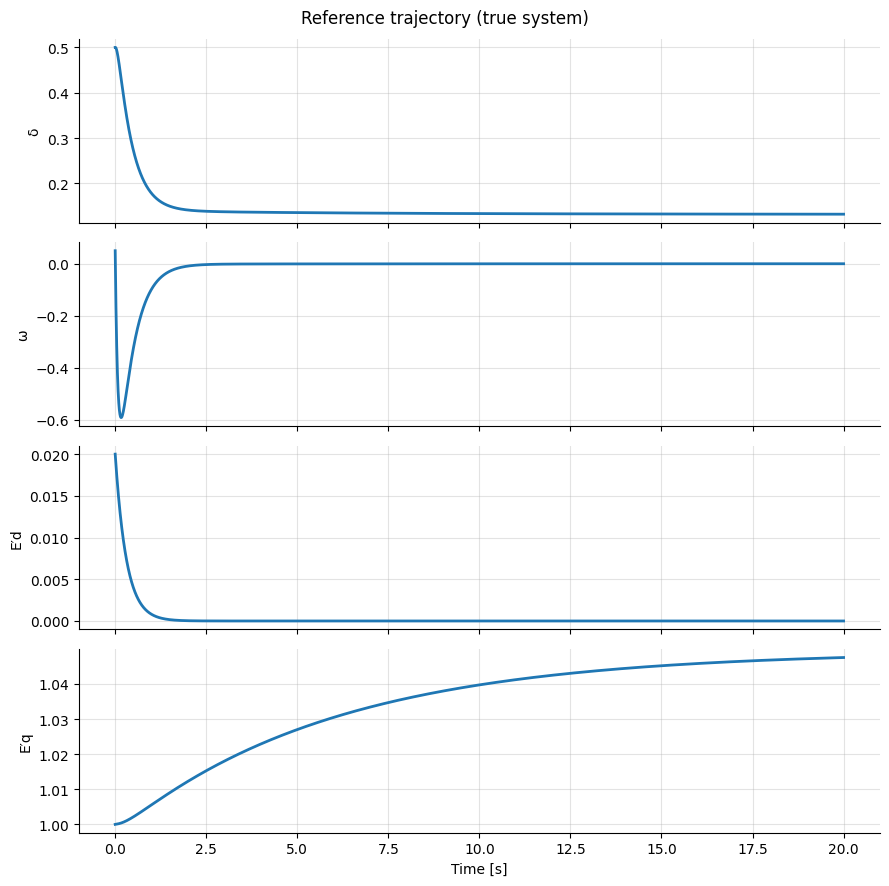

In [8]:
p = load_machine_params("params/machine1.yaml")

x0 = np.array([0.5, 0.05, 0.02, 1.0], dtype=float)
sol_ref = simulate(p, x0, t_end=20.0, n=20000)

plot_reference(sol_ref, STATE_LABELS, yscale=None, linthresh=1e-4,
               title="Reference trajectory (true system)")
plt.show()

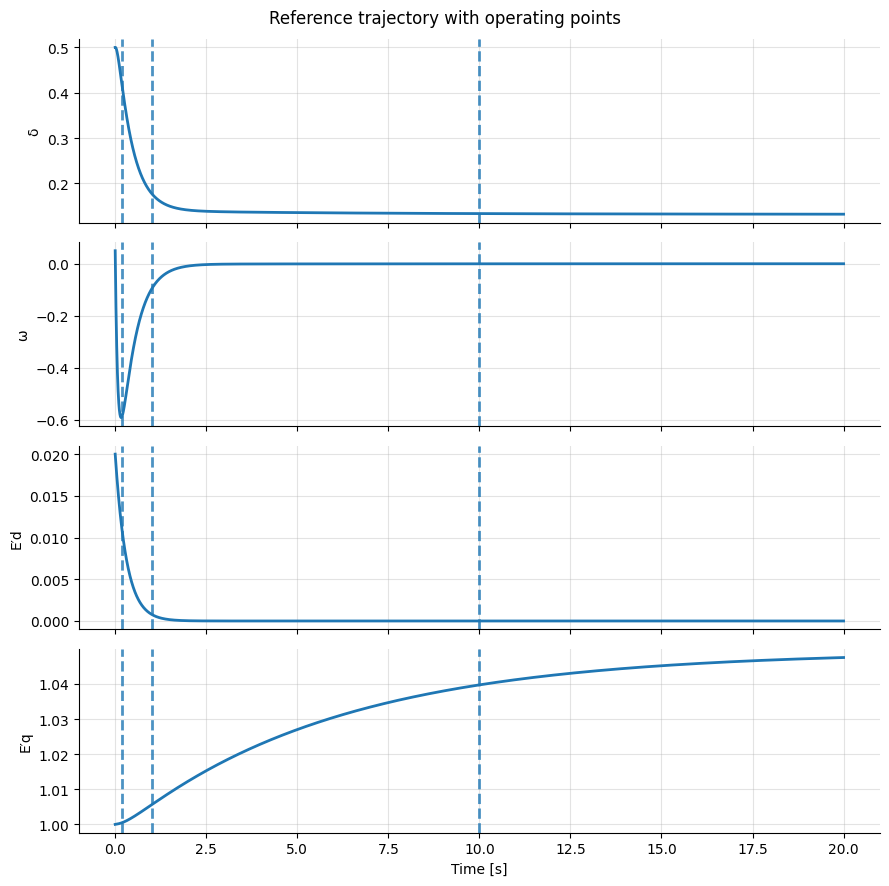

OP1_transient t_actual= 0.20001000050002501
OP2_intermediate t_actual= 1.000050002500125
OP3_slow_tail t_actual= 9.99949997499875


In [9]:
op_times = {
    "OP1_transient": 0.2,
    "OP2_intermediate": 1.0,
    "OP3_slow_tail": 10.0,
}

operating_points = extract_operating_points(sol_ref, op_times)

plot_reference_with_ops(sol_ref, operating_points, STATE_LABELS,
                        title="Reference trajectory with operating points")
plt.show()

for op in operating_points:
    print(op["op_id"], "t_actual=", op["t_actual"])

In [10]:
perturbations = {
    "small": np.array([0.01, 0.0, 0.0, 0.0]),
    "large": np.array([0.20, 0.0, 0.0, 0.0]),
}


OP1_transient  (t = 0.200010 s)
x_ref:
    δ = +0.409283
    ω = -0.582106
  E′d = +0.010491
  E′q = +1.000526

A = ∂f/∂x |_{x_ref}:
[[  0.       1.       0.       0.    ]
 [-32.8938 -15.708   30.9591 -16.4444]
 [  0.       0.      -3.2258   0.    ]
 [ -0.0235   0.       0.      -0.1707]]

Local modes (sorted by Re):


,mode,Re(λ),Im(λ),f [Hz],τ=-1/Re [s]
0,mode_1,-1.3217e+01,+0.0000e+00,0.0000,0.076
1,mode_2,-3.2258e+00,+0.0000e+00,0.0000,0.310
2,mode_3,-2.5037e+00,+0.0000e+00,0.0000,0.399
3,mode_4,-1.5803e-01,+0.0000e+00,0.0000,6.328


Summary: τ_slow≈6.328s, τ_fast≈0.076s, stiffness≈83.6, complex modes=0, f_dom=—

Participation (per mode, columns sum to 1):


,mode_1,mode_2,mode_3,mode_4
δ,0.16,0.00,0.84,0.01
ω,0.84,0.00,0.16,0.00
E′d,0.00,1.00,0.00,0.00
E′q,0.00,0.00,0.00,0.99


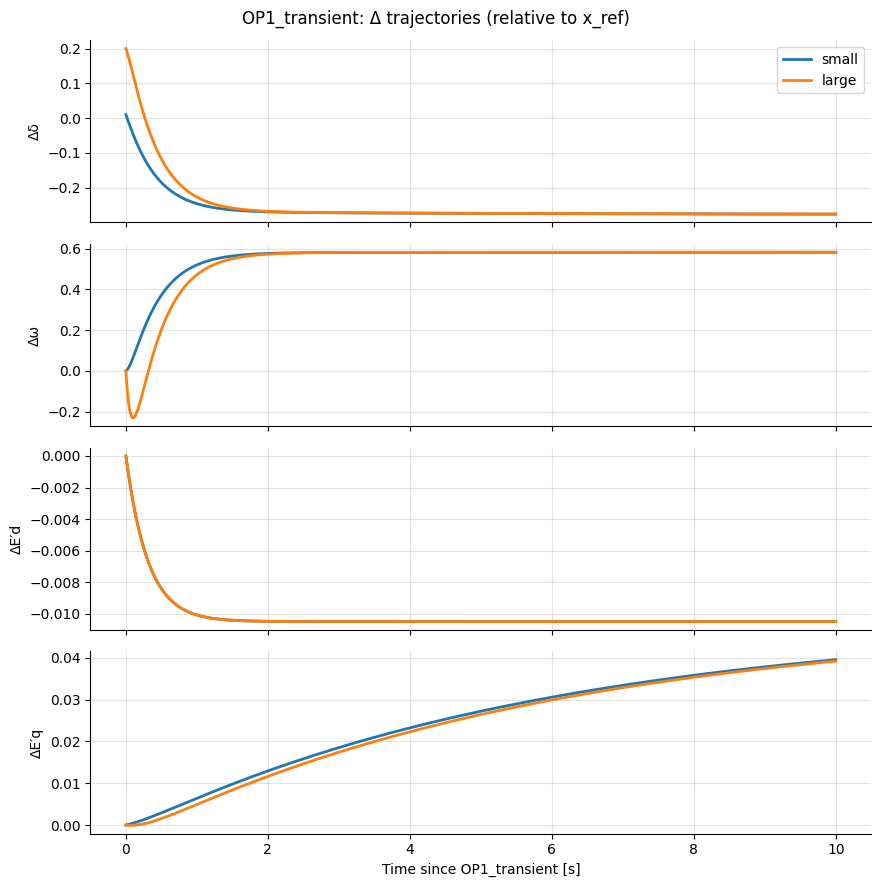


OP2_intermediate  (t = 1.000050 s)
x_ref:
    δ = +0.177982
    ω = -0.097405
  E′d = +0.000794
  E′q = +1.005583

A = ∂f/∂x |_{x_ref}:
[[  0.       1.       0.       0.    ]
 [-33.8003 -15.708   33.2132  -7.3159]
 [  0.       0.      -3.2258   0.    ]
 [ -0.0105   0.       0.      -0.1707]]

Local modes (sorted by Re):


,mode,Re(λ),Im(λ),f [Hz],τ=-1/Re [s]
0,mode_1,-1.3134e+01,+0.0000e+00,0.0000,0.076
1,mode_2,-3.2258e+00,+0.0000e+00,0.0000,0.310
2,mode_3,-2.5764e+00,+0.0000e+00,0.0000,0.388
3,mode_4,-1.6829e-01,+0.0000e+00,0.0000,5.942


Summary: τ_slow≈5.942s, τ_fast≈0.076s, stiffness≈78.0, complex modes=0, f_dom=—

Participation (per mode, columns sum to 1):


,mode_1,mode_2,mode_3,mode_4
δ,0.16,0.00,0.84,0.00
ω,0.84,0.00,0.16,0.00
E′d,0.00,1.00,0.00,0.00
E′q,0.00,0.00,0.00,1.00


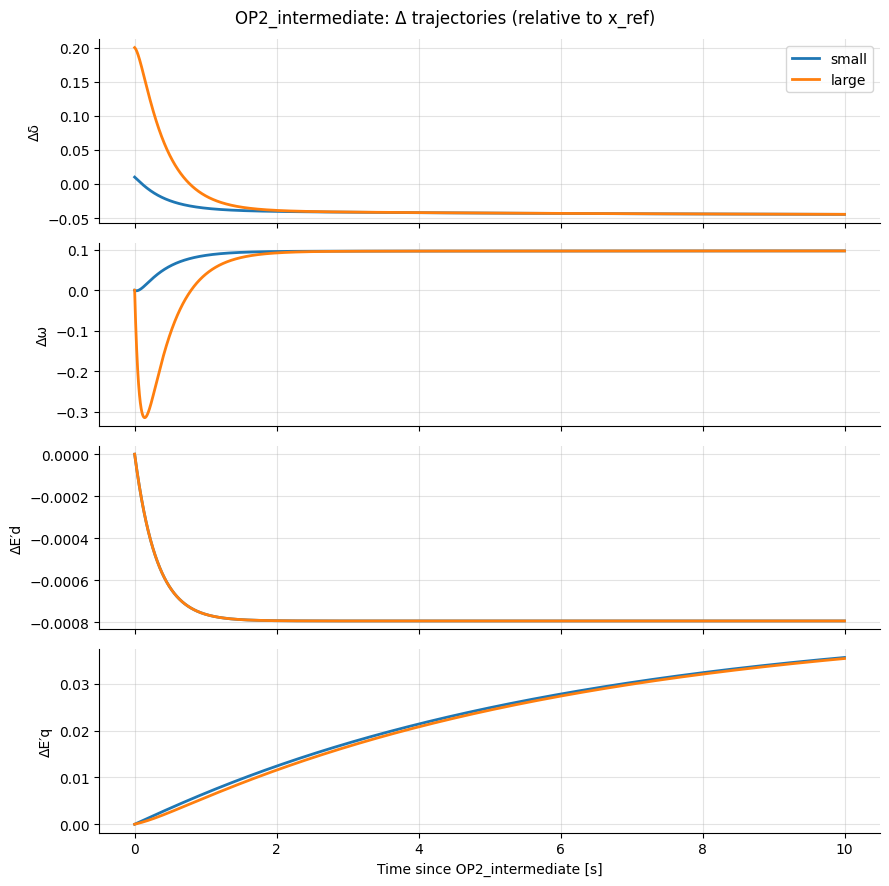


OP3_slow_tail  (t = 9.999500 s)
x_ref:
    δ = +0.133575
    ω = -0.000273
  E′d = +0.000000
  E′q = +1.039736

A = ∂f/∂x |_{x_ref}:
[[  0.       1.       0.       0.    ]
 [-35.2743 -15.708   33.4457  -5.5033]
 [  0.       0.      -3.2258   0.    ]
 [ -0.0079   0.       0.      -0.1707]]

Local modes (sorted by Re):


,mode,Re(λ),Im(λ),f [Hz],τ=-1/Re [s]
0,mode_1,-1.2993e+01,+0.0000e+00,0.0000,0.077
1,mode_2,-3.2258e+00,+0.0000e+00,0.0000,0.310
2,mode_3,-2.7165e+00,+0.0000e+00,0.0000,0.368
3,mode_4,-1.6941e-01,+0.0000e+00,0.0000,5.903


Summary: τ_slow≈5.903s, τ_fast≈0.077s, stiffness≈76.7, complex modes=0, f_dom=—

Participation (per mode, columns sum to 1):


,mode_1,mode_2,mode_3,mode_4
δ,0.17,0.00,0.83,0.00
ω,0.83,0.00,0.17,0.00
E′d,0.00,1.00,0.00,0.00
E′q,0.00,0.00,0.00,1.00


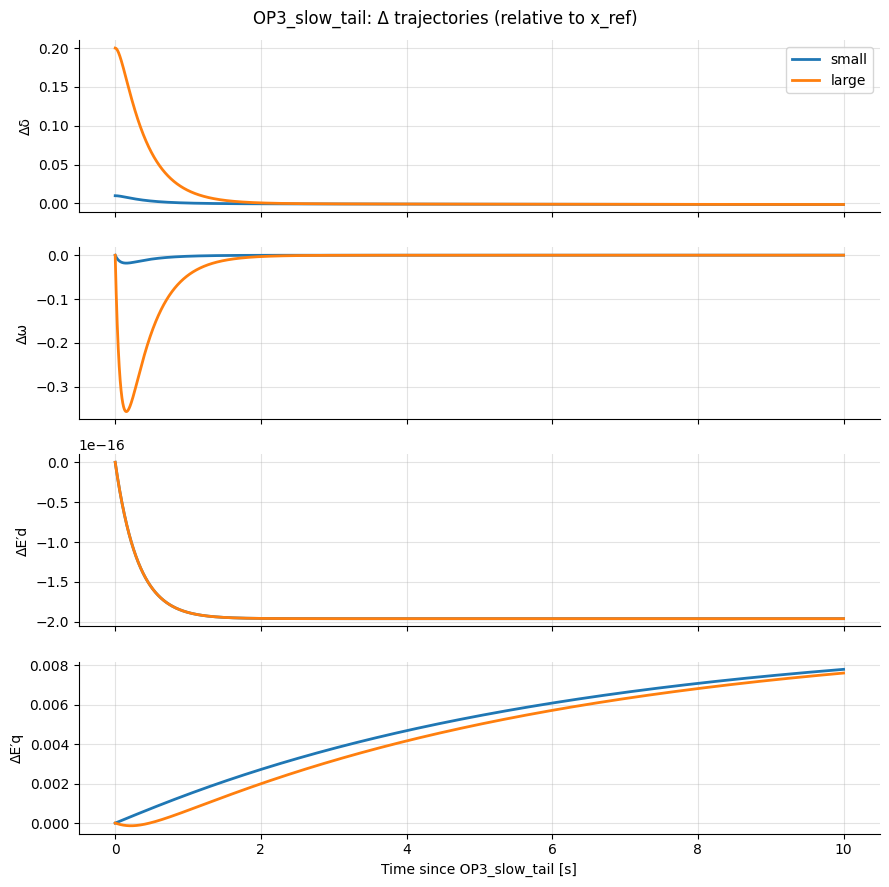

In [11]:
results = {}
state_labels = ["δ", "ω", "E′d", "E′q"]

for op in operating_points:
    op, ringdowns = analyze_operating_point(
        p, op,
        perturbations=perturbations,
        t_dist=10.0,
        n_dist=10000,
        jac_eps=1e-6
    )

    results[op["op_id"]] = {"op": op, "ringdowns": ringdowns}

    summarize_op_concise(op, state_labels, show_A=True)

    plot_delta_ringdowns(
        op, ringdowns, STATE_LABELS,
        title=f"{op['op_id']}: Δ trajectories (relative to x_ref)",
        yscale=None
    )
    plt.show()